# Photometric calibration

## Mangitudes and physical units

astropy includes mangitude units and the AB magnitude system (flux density per unit frequency), to which LSST will be calibrated:

In [1]:
import astropy.units as u

m = 18 * u.ABmag
print(m)

18.0 mag(AB)


In [2]:
fnu = m.to('W/(m2 Hz)')  # convert to linear units
print(fnu)

2.290867652767766e-30 W / (Hz m2)


---
When we want to convert to per unit wavelength space, we need a wavelength and the `spectral_density` "equivalency" generator:

In [3]:
flam = m.to('W/(m2 um)', u.spectral_density(550 * u.nm))
print(flam)

2.2703631225650876e-15 W / (m2 um)


See https://docs.astropy.org/en/stable/units/equivalencies.html for more on unit equivalencies.

sbpy introduces the VEGAmag unit, which is calibrated to the spectrum of Vega (0 mag at all wavelengths).  It may be convered to/from physical units using the `spectral_density_vega` equilvalency generator:

In [4]:
import sbpy.units as sbu

m = 18 * sbu.VEGAmag
m.to('W/(m2 um)', sbu.spectral_density_vega(550 * u.nm))

<Quantity 2.23795744e-15 W / (m2 um)>

## Bandpasses

sbpy has a few bandpasses defined for convenience:

In [5]:
from sbpy.photometry import bandpass

rp1 = bandpass('PS1 r')  # PanSTARRS r-band

sbpy is built upon STScI's synphot, and the returned object is a `synphot.SpectralElement`:

In [6]:
print(type(rp1))

<class 'synphot.spectrum.SpectralElement'>


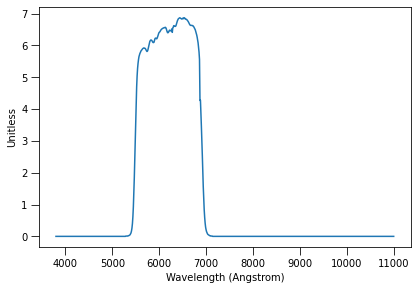

In [7]:
rp1.plot()

See the synphot documentation for more on how to use `SpectralElement`: https://synphot.readthedocs.io/en/latest/synphot/bandpass.html.

Here, we use the r-band's pivot wavelength to transform from the AB magnitude system (defined in flux density per unit frequency) to flux density per unit wavelength:

In [8]:
m = 18 * u.ABmag
print(m.to('W/(m2 um)', u.spectral_density(rp1.pivot())))

1.7859583290057543e-15 W / (m2 um)


## Solar spectrum

sbpy includes a spectrum of the Sun, and the option to download others, or define your own:

In [9]:
from sbpy.calib import Sun

sun = Sun.from_default()
print(sun)

<Sun: E490-00a (2014) reference solar spectrum (Table 3)>


In [10]:
Sun.show_builtin()

    name                                description                           
------------ -----------------------------------------------------------------
Castelli1996      Castelli model, scaled and presented by Colina et al. (1996)
   E490_2014                E490-00a (2014) reference solar spectrum (Table 3)
 E490_2014LR E490-00a (2014) low resolution reference solar spectrum (Table 4)
  Kurucz1993               Kurucz (1993) model, scaled by Colina et al. (1996)


**The URLs for the Castelli and Kurucz will be updated in a future bug-fix.**  Otherwise, one would be able to get these spectra with, e.g., `Sun.from_builtin('Castelli1996')`.

Using sbpy's bibliography tracking module, we can get the reference for the data:

In [11]:
from sbpy import bib

bib.track()
sun = Sun.from_default()
sun(0.5 * u.um)
bib.stop()
print(bib.show())  # with the `ads` module set up, use bib.to_text()

sbpy:
  software: sbpy:
    2019JOSS....4.1426M
sbpy.calib.core.Sun:
  E490-00a (2014) reference solar spectrum (Table 3):
    doi:10.1520/E0490



---
Observe the Sun through the V-band and PS1 r-band filters:

In [12]:
V = bandpass('Johnson V')
lambda_eff, fluxd = sun.observe_bandpass(V)
print(lambda_eff, fluxd)

5502.343574280301 Angstrom 1839.9327322721458 W / (m2 um)


In [13]:
lambda_eff, m = sun.observe_bandpass(V, unit=u.ABmag)
print(m)

-26.763599066027865 mag(AB)


In [14]:
lambda_eff, m = sun.observe_bandpass(rp1, unit=u.ABmag)
print(m)

-26.928330738233477 mag(AB)


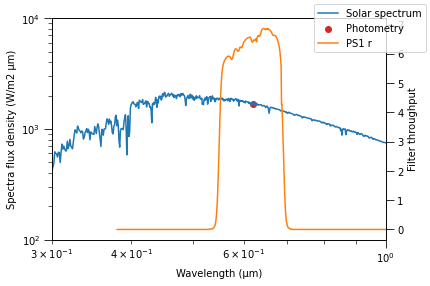

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
ax = plt.gca()

# plot the solar spectrum
ax.plot(sun.wave.to('um'), sun.fluxd, label='Solar spectrum')

# observe the sun with the PS1 r-band filter and plot the result
lambda_eff, fluxd = sun.observe_bandpass(rp1, unit=sun.fluxd.unit)
ax.scatter([lambda_eff.to_value('um')], [fluxd.value], color='tab:red', label='Photometry')

# plot the filter throughput
rax = ax.twinx()
w = rp1.waveset.to('um')
rax.plot(w, rp1(w), color='tab:orange', label='PS1 r')

# define plot parameters
plt.setp(ax, xscale='log', yscale='log',
         xlim=(0.3, 1.0), ylim=(1e2, 1e4),
         xlabel='Wavelength (μm)', ylabel='Spectra flux density (W/m2 μm)')
rax.set_ylabel('Filter throughput')
fig.legend()
plt.tight_layout()

---

As an alternative to computing the brightness of the Sun with a spectrum and bandpass, the calculations of Willmer (2018) are included and may be used throughout sbpy by quoting the bandpass name.  For example:

In [16]:
from sbpy.calib import solar_fluxd

lambda_eff, lambda_pivot, m = sun.observe_filter_name('LSST r', unit=u.ABmag)
print(m)

-26.933406243563084 mag(AB)


In [17]:
solar_fluxd.get()  # show all available filters

{'2MASS H': <Quantity 23.1206479 erg / (Angstrom cm2 s)>,
 '2MASS H(lambda pivot)': <Quantity 1.6495 um>,
 '2MASS H(lambda eff)': <Quantity 1.6424 um>,
 '2MASS J': <Quantity 46.13175746 erg / (Angstrom cm2 s)>,
 '2MASS J(lambda pivot)': <Quantity 1.2393 um>,
 '2MASS J(lambda eff)': <Quantity 1.2321 um>,
 '2MASS Ks': <Quantity 9.12010839 erg / (Angstrom cm2 s)>,
 '2MASS Ks(lambda pivot)': <Quantity 2.1638 um>,
 '2MASS Ks(lambda eff)': <Quantity 2.1558 um>,
 'ACS F330W': <Quantity 100. erg / (Angstrom cm2 s)>,
 'ACS F330W(lambda pivot)': <Quantity 0.3521 um>,
 'ACS F330W(lambda eff)': <Quantity 0.3523 um>,
 'ACS F410W': <Quantity 151.35612484 erg / (Angstrom cm2 s)>,
 'ACS F410W(lambda pivot)': <Quantity 0.4064 um>,
 'ACS F410W(lambda eff)': <Quantity 0.4096 um>,
 'ACS F435W': <Quantity 178.64875749 erg / (Angstrom cm2 s)>,
 'ACS F435W(lambda pivot)': <Quantity 0.4328 um>,
 'ACS F435W(lambda eff)': <Quantity 0.4341 um>,
 'ACS F475W': <Quantity 190.5460718 erg / (Angstrom cm2 s)>,
 'ACS F

## Brightness, reflectance, and cross-sectional area

sbpy can convert between brightness, reflectance, and cross section for solid bodies using astropy's unit equivalencies framework.  We already used unit equivalences in the photometric calibration notebook, when we converted between spectral flux density units transforming data from per unit frequency to per unit wavelength using `u.spectral_density()`.  Here, we use sbpy's `reflectance` function.

>  ⚠️ Small API changes are expected in sbpy v0.4 in order to make the terminology more precise.  However, the flavor of the conversions will remain the same.

In [18]:
import numpy as np
import astropy.units as u
import sbpy.units as sbu

H = 3.4 * sbu.VEGAmag  # Ceres's absolute magnitude in V
refl = 0.029 / u.sr     # Ceres's reflectance
cross_section = H.to('km2', sbu.reflectance('Johnson V', reflectance=refl))
D = np.sqrt(cross_section / np.pi)
print(D)

460.1780010358774 km


In [19]:
# or compute absolute magnitude from diameter and reflectance
refl = 0.067 / np.pi / u.sr  # (24) Themis geometric albedo / pi
D = 198 * u.km       # and diameter
cross_section = np.pi * D**2 / 4
H = refl.to(sbu.VEGAmag, sbu.reflectance('Johnson V', cross_section=cross_section))
print(H)  # compare to JPL SBDB's H=7.25 mag

7.070135962918318 mag(VEGA)


Again, more precise concepts of albedo and reflectance are expected in v0.4.